This is an implementation of an lstm for weather forecasting. GIven weather history say in the past 20 days, predicts the weather in the next 5 days.

In [ ]:
import torch, sys, pickle
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import *
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, stdev

In [ ]:
#Enable same random initialization every time we run this code.
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

All Methods

In [ ]:
#Preprocess the data
def preprocess(hwindow, fwindow, dfs):
    '''
    Remove unwanted column i.e. date-time
    Takes only one observation a day 
    Normalize the data
    Rearrange data into (input,output) fashion
    '''
    index=0
    data = []
    label = []
    dfs = dfs.drop(['Date Time'], axis=1)
    dfs = dfs.iloc[::6, :] #One observation an hour.
    std_scale = preprocessing.StandardScaler().fit(dfs)
    dfs = std_scale.transform(dfs)
    while index < len(dfs):
          inpt = dfs[index:index + hwindow,:].tolist()
          output = dfs[index+hwindow:index+hwindow+fwindow,:].tolist()
          if(len(inpt) == hwindow and (len(output)==fwindow or len(output)==0)): 
            data.append(inpt)
            label.append(output)
          index=index+hwindow
    data = torch.tensor(data)
    label = torch.tensor(label)
    return data, label

#The Model
class lstm(nn.Module):
    def __init__(self, inpt_dim, hidden_dim, num_layers, output_dim, dropout):
        super(lstm, self).__init__()
        self.lstmLayer = nn.LSTM(inpt_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.outputLayer = nn.Linear(hidden_dim * num_layers, output_dim)
        self.dropout = nn.Dropout(dropout)

        
    def forward(self,inpt):   
        batc_size = inpt.shape[0]
        timestep_outputs, (final_output,cell_output) = self.lstmLayer(inpt)
        f = self.dropout(torch.cat((final_output[-2,:,:], final_output[-1,:,:]), dim = 1))
        f = torch.cat((final_output[-2,:,:], final_output[-1,:,:]), dim = 1)
        lstm_scores = self.outputLayer(f)
        lstm_scores = lstm_scores.reshape(batc_size,-1,inpt_dim)
        return lstm_scores


#Train
def train(model, xtrain, ytrain, optimizer, lossFunction):
    losses = []
    model.train()
    index = 0

    while index < len(xtrain):
        inpt = xtrain[index:index+batch_size]
        target = ytrain[index:index+batch_size]
        index += batch_size

        optimizer.zero_grad()
        modeloutput = model(inpt.float())
        loss = lossFunction(modeloutput, target.float())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses


#Evaluate
def evaluate(model, xtest, ytest): 
    model.eval()
    index = 0
    losses = []
    
    with torch.no_grad():   
         while index < len(xtest):       
               inpt = xtest[index:index+batch_size]
               target = ytest[index:index+batch_size]
               index += batch_size

               modeloutput = model(inpt.float())
               mse = lossFunction(modeloutput, target.float())
               losses.append(mse.item())
    return sum(losses)/len(losses)

def predict(model,inpt): 
    '''
    This code assumes, inpt is of shape 1*hwindow*inpt_dim i.e. a batch size of one.
    And outputs a tensor of shape 31*fwindow*inpt_dim
    '''
    index = 0
    i = 0
    output = []
    while i<31:
            model_output = model(inpt.float())
            output.append(model_output.tolist())
            inpt = inpt[:,fwindow:,:]
            inpt = torch.cat((inpt[0,:,:],model_output[0,:,:]),0)
            inpt = inpt.reshape(1,-1,inpt_dim)
            i=i+1
    return torch.tensor(output).squeeze(1)


Get and prepare data

In [ ]:
#Get data
df = pd.read_csv("drive/MyDrive/Colab Notebooks/jena_climate_2009_2016.csv", sep=',', delimiter=None, header='infer')

In [ ]:
#Preprocess data
avg_temp = mean(df["T (degC)"])
std_temp = stdev(df["T (degC)"])
hwindow = 168 #history window i.e. 1 week
fwindow = 24  #forecast window i.e. 24 hrs
inpt_dim = 14 #number of features in one observation (temp,humid,wind etc)
data,label = preprocess(hwindow, fwindow, df)

In [ ]:
#Split into train-dev sets
xtrain, xtest, ytrain, ytest = train_test_split(data, label, test_size=0.3)

In [ ]:
#Deallocate some memory
del data
del label

Train the model

In [ ]:
#Global variables
hidden_dim = 256
num_layers = 2
output_dim = fwindow*inpt_dim  
batch_size = 64
dropout = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = lstm(inpt_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
lossFunction = nn.MSELoss()
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad == True], lr=0.001)

In [ ]:
#Train and Compute loss
losses = []
max_loss = float('inf')
for epoch in range(0, 50):
    epoch_losses = train(model, xtrain, ytrain, optimizer, lossFunction)
    loss_sum = sum(epoch_losses)
    losses.append(loss_sum)
    if loss_sum < max_loss:
       max_loss = loss_sum
       torch.save(model.state_dict(), 'best_model.pt')
np.savetxt("losses.csv", losses, delimiter=",")

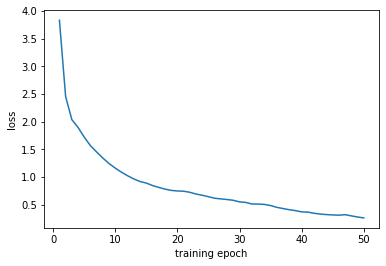

In [ ]:
#Plot losses
epoches = range(1,len(losses)+1)
plt.figure()
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.plot(epoches, losses) 
plt.show()

Evaluate

In [ ]:
#Report MSE
model.load_state_dict(torch.load('best_model.pt'))
mse = evaluate(model, xtest, ytest)
print("MSE is %s" %(mse))

MSE is 0.26666224002838135


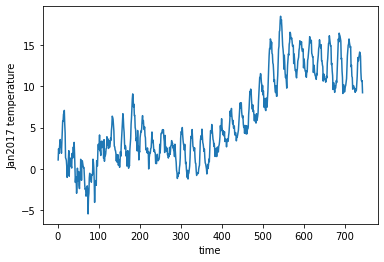

In [ ]:
#Predict jan2017 weather:
inpt = df.tail(1008) #get dec2016 last week's data
data,label = preprocess(hwindow,fwindow,inpt)
out = predict(model, data)
temp_dim = 1
predictions = out[:,:,temp_dim].flatten().tolist()
predictions = [(item*std_temp)+avg_temp for item in predictions] 

#Plot predictions
timeline = range(1,len(predictions)+1)
plt.figure()
plt.xlabel('time')
plt.ylabel('Jan2017 temperature')
plt.plot(timeline, predictions) 
plt.show()

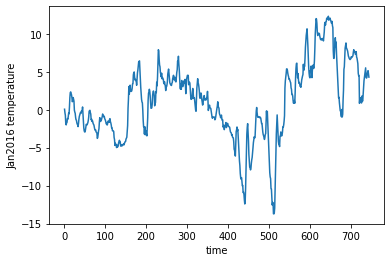

In [ ]:
#Plot january temperatures in any other year
inpt = df.iloc[368293:372756,:] #get jan 2016's data
inpt = inpt.iloc[::6, :] #One observation an hour.
jan2016 = inpt["T (degC)"].values
timeline = range(1,len(jan2016)+1)
plt.figure()
plt.xlabel('time')
plt.ylabel('Jan2016 temperature')
plt.plot(timeline, jan2016) 
plt.show()